This notebook contains a Finetuned BERT from Huggingface

BERT Paper: https://arxiv.org/pdf/1810.04805.pdf

### Library Installations

In [1]:
!pip install bertviz transformers torch torchtext tqdm captum seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylin

### Library Imports

In [2]:
from google.colab import drive
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, get_scheduler, Trainer, TrainingArguments
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics
from tqdm.auto import tqdm
from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import datetime
import seaborn as sns

### Folder Constants

In [3]:
BERT_MODEL = 'bert-base-uncased'
FOLDER_PATH = '/content/drive/MyDrive/cs4248/'
DATASET_PATH = os.path.join(FOLDER_PATH, 'datasets')
ORIGINAL_DATASET_PATH = os.path.join(DATASET_PATH, 'lun_dataset_original')
ORIGINAL_TEST_DATASET_FILE_NAME = 'test_final_with_topics_new.csv'
MIXED_DATASET_PATH = os.path.join(DATASET_PATH, 'lun_dataset_modified')
MIXED_DATASET_TRAIN_FILE_NAME = 'merged_final_df_with_topics_new.csv'
# TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
TIMESTAMP = "20240411-110024"
MODEL_SAVE_PATH = os.path.join(FOLDER_PATH, 'models', BERT_MODEL, TIMESTAMP)

### Device Constants

In [4]:
TORCH_DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

### Mount Google Drive

In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare Dataset

In [6]:
test_dataframe = pd.read_csv(os.path.join(MIXED_DATASET_PATH, ORIGINAL_TEST_DATASET_FILE_NAME))

### Model Constants

In [7]:
TOKEN_MAX_LENGTH = 512
TRAIN_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8
EPOCHS = 3
LEARNING_RATE = 3e-5
N_CLASSES = len(set(test_dataframe['label']))

### Model


In [8]:
bert_config = BertConfig.from_pretrained(BERT_MODEL, output_hidden_states=True, output_attentions=True, num_labels=N_CLASSES)
model = BertForSequenceClassification.from_pretrained(BERT_MODEL, config=bert_config)
# model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Criterion

In [9]:
def criterion(outputs, targets):
  return nn.CrossEntropyLoss()(outputs, targets)

### Prepare Model Dataset

In [10]:
# LUN Dataset Class
class BertLUNDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.text[index]
        label = self.data.label[index] - 1  # Subtract 1 to map indices to range [0, num_classes-1]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }


### Loading the tokenizer

In [11]:
tokenizer = BertTokenizer.from_pretrained(MODEL_SAVE_PATH)

### Load the model


In [12]:
saved_model_path = os.path.join(MODEL_SAVE_PATH, 'bert_model_optim.pth')
# saved_model_path

In [13]:
checkpoint = torch.load(saved_model_path)

In [14]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [15]:
optimizer = torch.optim.Adam(params = model.parameters(),  lr=LEARNING_RATE)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


In [16]:
for param in model.parameters():
    param.requires_grad = False

model.to(TORCH_DEVICE)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Test the loaded model

In [17]:
# Prepare Test Dataloader
test_dataset = BertLUNDataset(test_dataframe, tokenizer, TOKEN_MAX_LENGTH)
test_dataloader = DataLoader(test_dataset, batch_size=TRAIN_BATCH_SIZE)

Functions for evaluating the model

In [18]:
from tqdm import tqdm
from sklearn.metrics import f1_score

def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with tqdm(total=len(data_loader), desc='Training') as pbar:
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()

            outputs = model(input_ids, attention_mask=attention_mask)

            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_samples += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            loss = loss_fn(outputs.logits, labels)
            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            pbar.update(1)

    train_f1 = f1_score(all_labels, all_preds, average='weighted')
    return correct_predictions.double() / total_samples, sum(losses) / len(losses), train_f1

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        with tqdm(total=len(data_loader), desc='Evaluation') as pbar:
            for batch in data_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['label'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)

                _, preds = torch.max(outputs.logits, dim=1)
                correct_predictions += torch.sum(preds == labels)
                total_samples += labels.size(0)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                loss = loss_fn(outputs.logits, labels)
                losses.append(loss.item())

                pbar.update(1)

    val_f1 = f1_score(all_labels, all_preds, average='weighted')
    return correct_predictions.double() / total_samples, sum(losses) / len(losses), val_f1

In [19]:
# Evaluation
val_acc, val_loss, val_f1 = eval_model(model, test_dataloader, criterion, TORCH_DEVICE)


Evaluation: 100%|██████████| 375/375 [02:11<00:00,  2.85it/s]


In [20]:
print(val_acc, val_loss, val_f1)

tensor(0.6098, device='cuda:0', dtype=torch.float64) 2.6585416060130034 0.5511027761001801


## Captum

In [21]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import torch
import matplotlib.pyplot as plt

In [22]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [23]:
def predict(input_ids, attention_mask=None):
    output = model(input_ids, attention_mask=attention_mask)
    return output.logits

# Need to pass a batch from the test dataloader
def custom_forward(input_ids, attention_mask=None):
    pred = predict(input_ids=input_ids, attention_mask=attention_mask)
    return pred.max(1).values

def custom_forward_with_emb(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

In [24]:
lig = LayerIntegratedGradients(custom_forward, model.bert.embeddings)

In [25]:
def construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id):
    text_ids = tokenizer.encode(text, add_special_tokens=False)
    # construct input token ids
    input_ids = [cls_token_id] + text_ids + [sep_token_id]
    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=TORCH_DEVICE), torch.tensor([ref_input_ids], device=TORCH_DEVICE), len(text_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=TORCH_DEVICE)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=TORCH_DEVICE)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=TORCH_DEVICE)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=TORCH_DEVICE)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(input_ids, ref_input_ids, token_type_ids=None, ref_token_type_ids=None, position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)

    return input_embeddings, ref_input_embeddings



In [26]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [27]:
reset_labels = test_dataframe["label"].apply(lambda x : x -1 )

In [28]:
label_class = {
    0: 'Satire',
    1: 'Hoax',
    2: 'Propaganda',
    3: 'Reliable'
}

In [29]:
def get_visualizations(text, label):
  input_ids, ref_input_ids, sep_id = construct_input_ref_pair(text, ref_token_id, sep_token_id, cls_token_id)
  token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
  attention_mask = construct_attention_mask(input_ids)
  indices = input_ids[0].detach().tolist()
  all_tokens = tokenizer.convert_ids_to_tokens(indices)

  attributions, delta = lig.attribute(inputs=input_ids,
                                    baselines=ref_input_ids,
                                    n_steps=700,
                                    internal_batch_size=3,
                                    return_convergence_delta=True)
  # print(f"calculated attributions.shape as {attributions.shape}")

  attributions_sum = summarize_attributions(attributions)
  # print(f"calculated attributions_sum.shape as {attributions_sum.shape} | sum sum is {attributions_sum.sum()}")

  logits = predict(input_ids, attention_mask)
  logits = torch.softmax(logits, dim = 1)
  argmax = torch.argmax(logits, dim=1).item()
  # print(f"logits are {logits} argmax is {torch.argmax(logits, dim=1)}")

  score_vis = viz.VisualizationDataRecord(attributions_sum,
                                        logits[0][argmax],
                                        label_class[argmax],
                                        label_class[label],
                                        text,
                                        attributions_sum.sum(),
                                        all_tokens,
                                        delta)

  print('\033[1m', 'Visualization For Score', '\033[0m')
  viz.visualize_text([score_vis])

  # now getting heatmap of attributions across all layers
  layer_attrs_start = []

  # The token that we would like to examine separately.
  token_to_explain = len(input_ids)//2 # the index of the token that we would like to examine more thoroughly
  layer_attrs_start_dist = []

  input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids)

  for i in range(model.config.num_hidden_layers):
      lc = LayerConductance(custom_forward_with_emb, model.bert.encoder.layer[i])
      layer_attributions_start, _ = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 0))
      # print(layer_attributions_start.shape, len(layer_attributions_start))
      layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())

      # storing attributions of the token id that we would like to examine in more detail in token_to_explain
      layer_attrs_start_dist.append(layer_attributions_start[0,token_to_explain,:].cpu().detach().tolist())

  print("Heatmap")
  fig, ax = plt.subplots(figsize=(45,15))
  xticklabels=all_tokens
  yticklabels=list(range(1,13))
  ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
  plt.xlabel('Tokens')
  plt.ylabel('Layers')
  plt.show()


Generating visualizations for satire example from test dataset

In [30]:
s_text = "Disney World is the happiest place on earth, but its also a well-oiled machine. Costumed performers have to follow strict guidelines to make sure they stay within Disneys vision for their particular character. Check out this fascinating handbook for playing Aladdin that one former employee released: Wow...pretty incredible, right? It really gives you a whole new level of appreciation for the careful behind-the-scenes planning that goes into making dreams come true."
s_label = 0 #satire

 Visualization For Score 


Heatmap


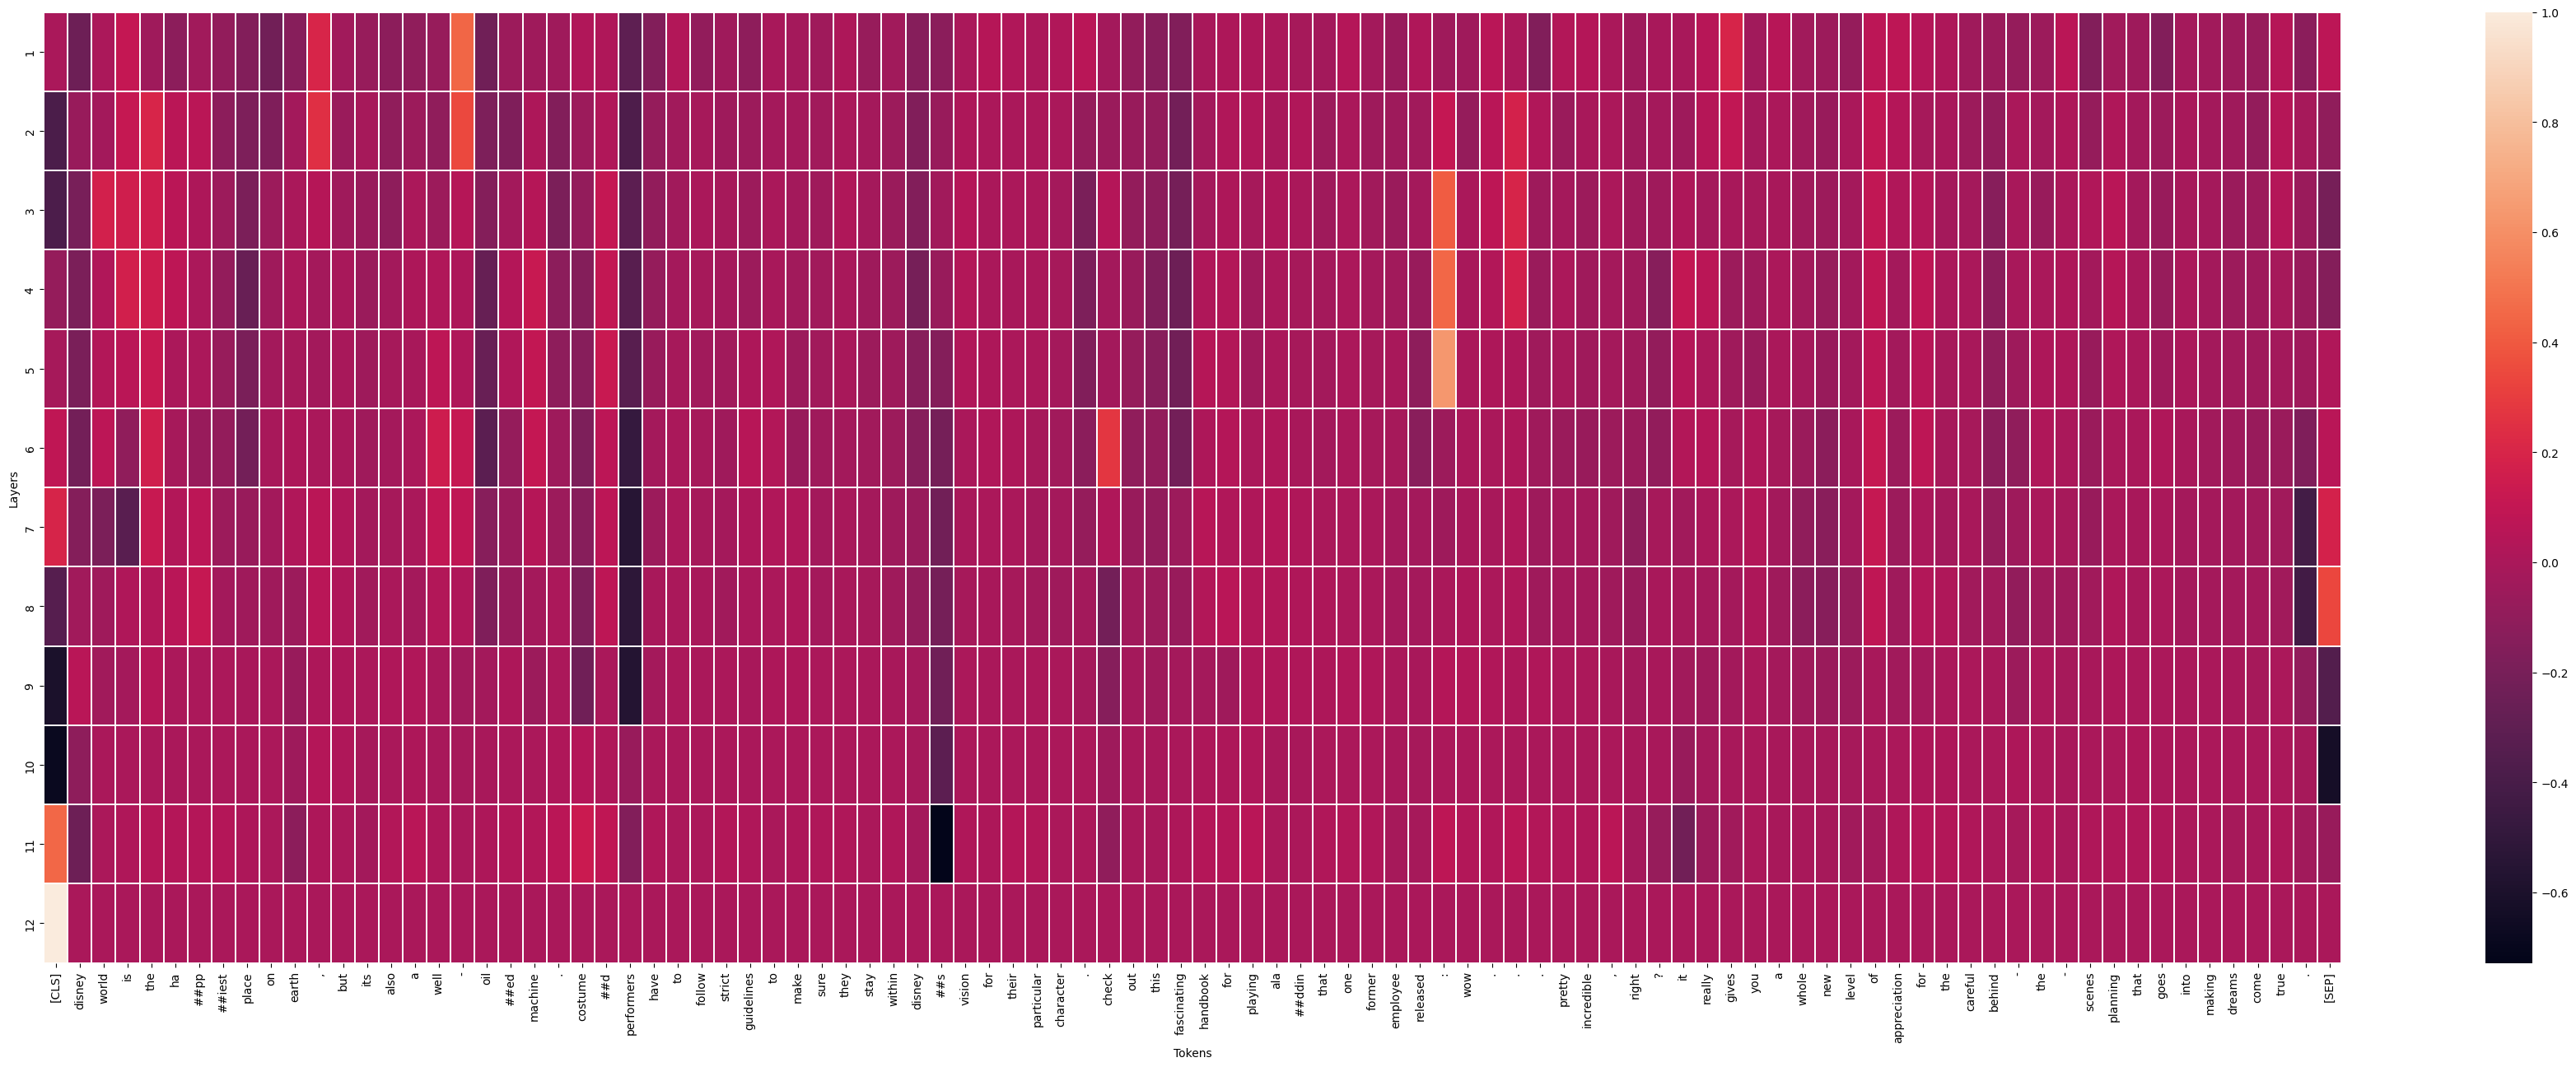

In [31]:
get_visualizations(s_text, s_label)

Generating visualizations for reliable example from test dataset

In [32]:
r_text = "Results Sunday from the Japan Open, a $1.2 million ATP event on hard courts at Ariake Colosseum (seedings in parentheses): Singles Final Jo-Wilfried Tsonga (2), France, def. Mikhail Youzhny, Russia, 6-3, 6-3. Doubles Final Julian Knowle and Jurgen Melzer, Austria, def. Ross Hutchins, Britain, and Jordan Kerr, Australia, 6-2, 5-7, 10-8."
r_label = 3 #reliable

 Visualization For Score 


Heatmap


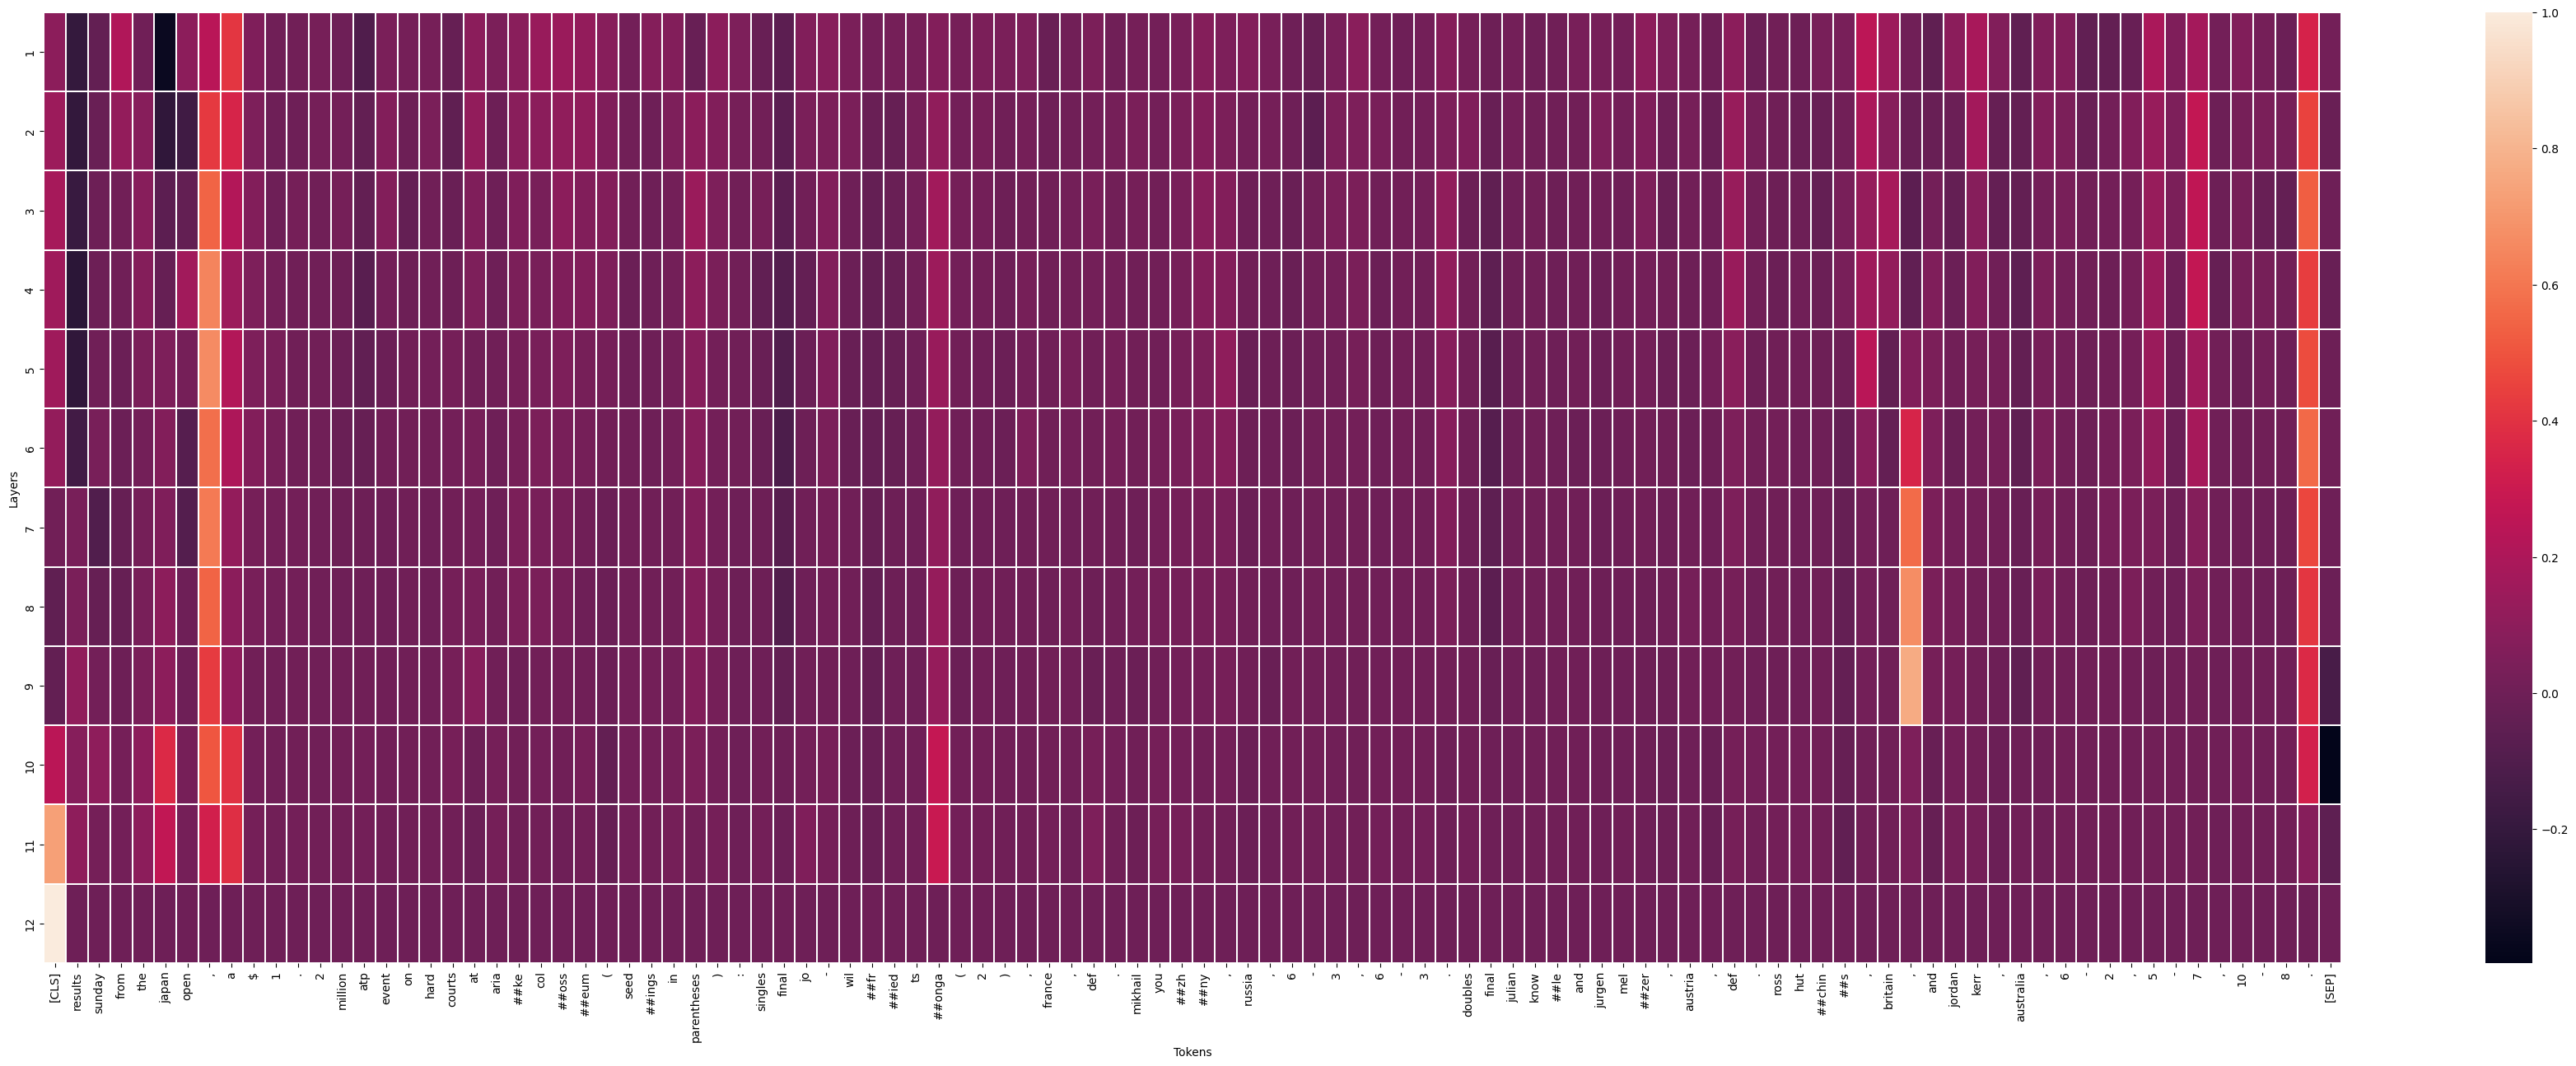

In [33]:
get_visualizations(r_text, r_label)

Some custom examples

 Visualization For Score 


Heatmap


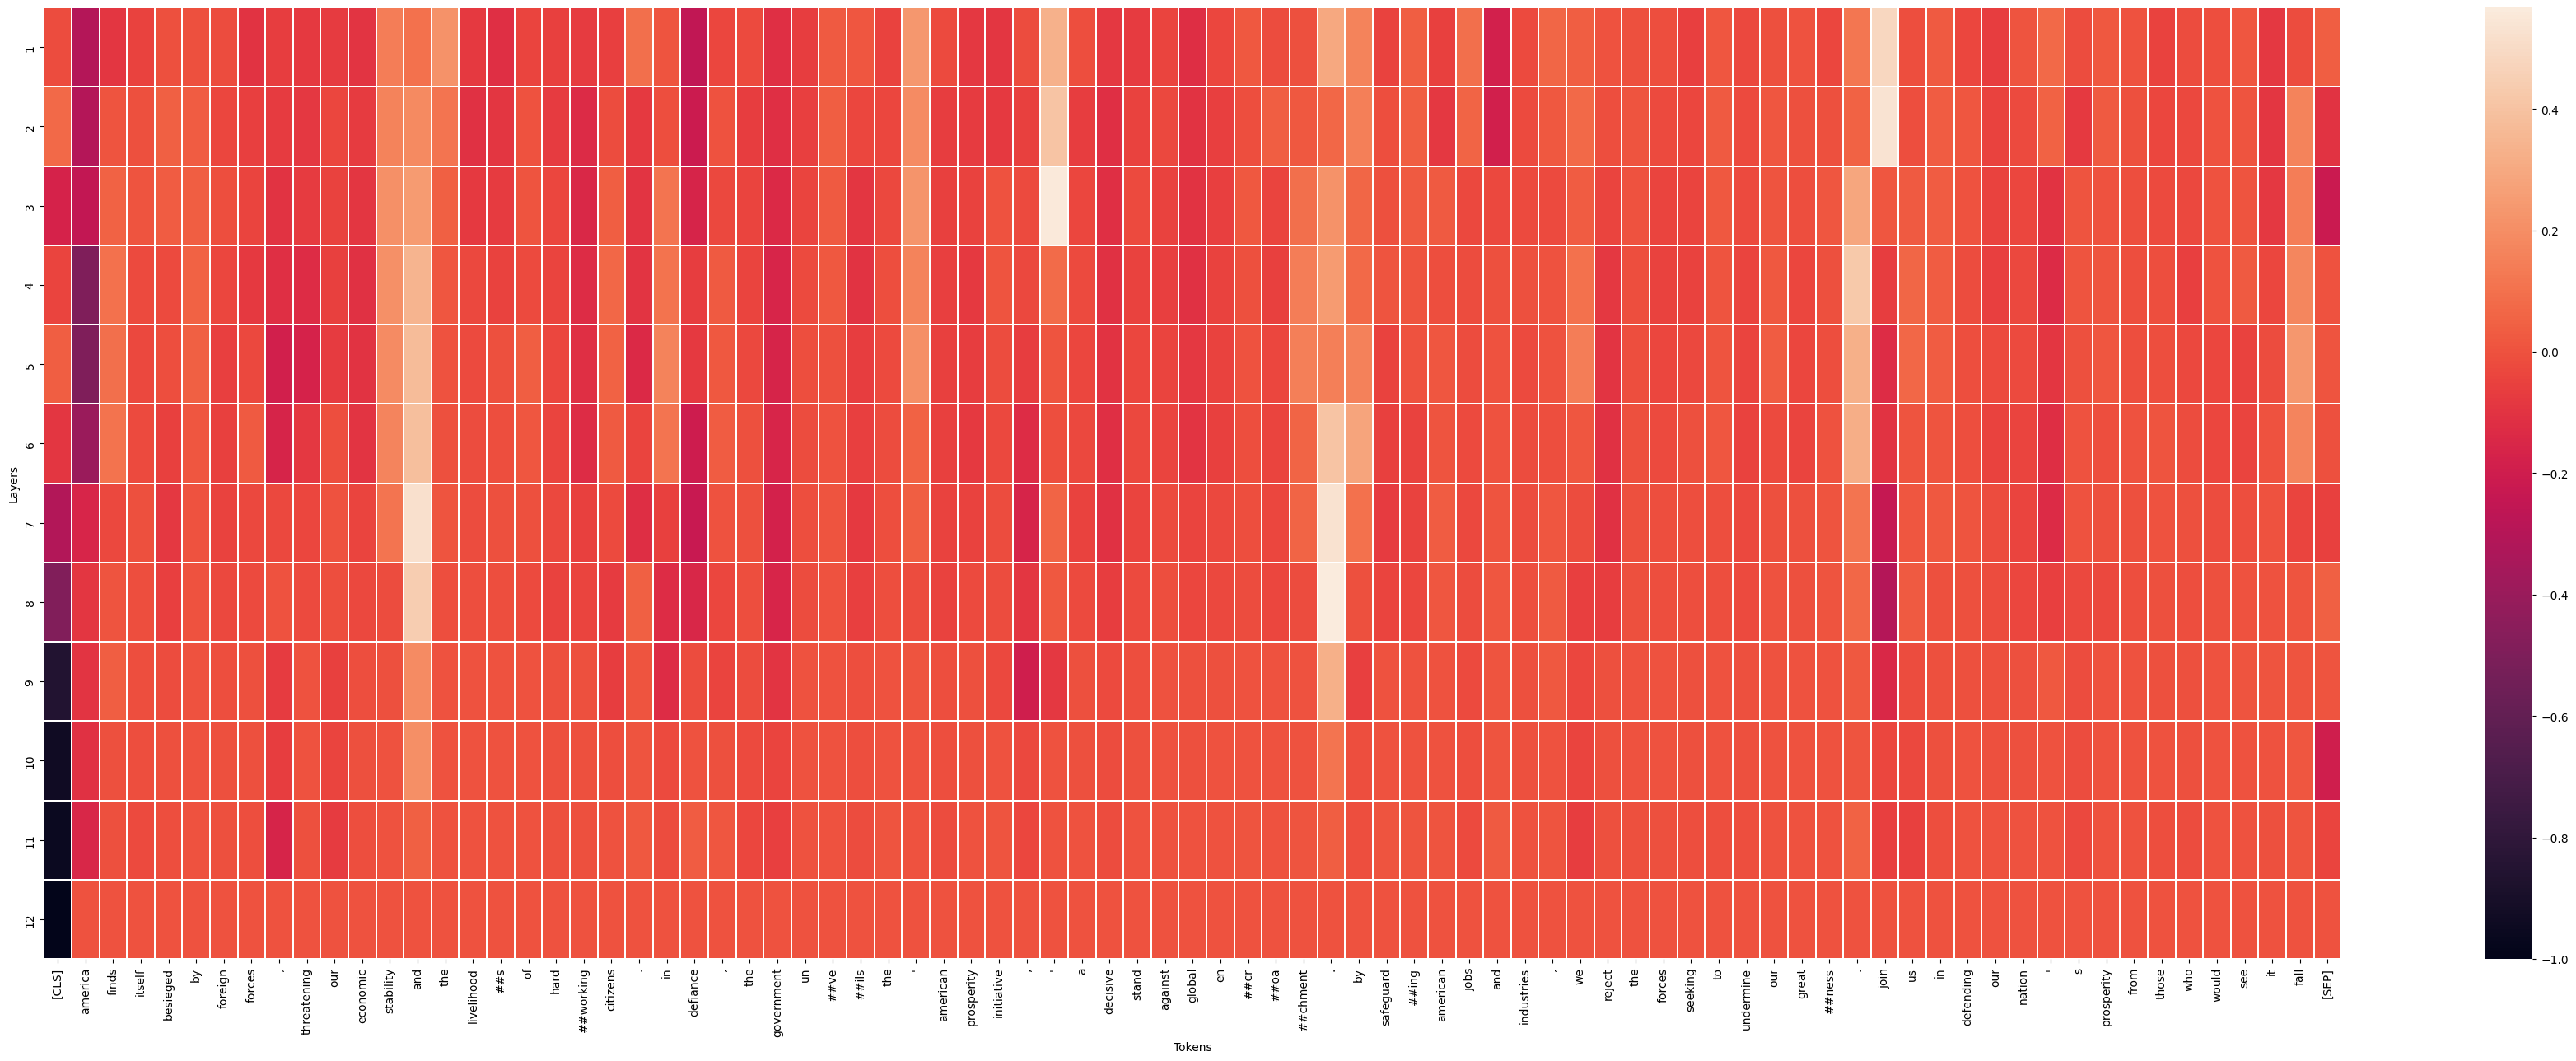

In [34]:
text_1 = "America finds itself besieged by foreign forces, threatening our economic stability and the livelihoods of hardworking citizens. In defiance, the government unveils the 'American Prosperity Initiative,' a decisive stand against global encroachment. By safeguarding American jobs and industries, we reject the forces seeking to undermine our greatness. Join us in defending our nation's prosperity from those who would see it fall"
label_1 = 2 #Propoganda

get_visualizations(text_1, label_1)

 Visualization For Score 


Heatmap


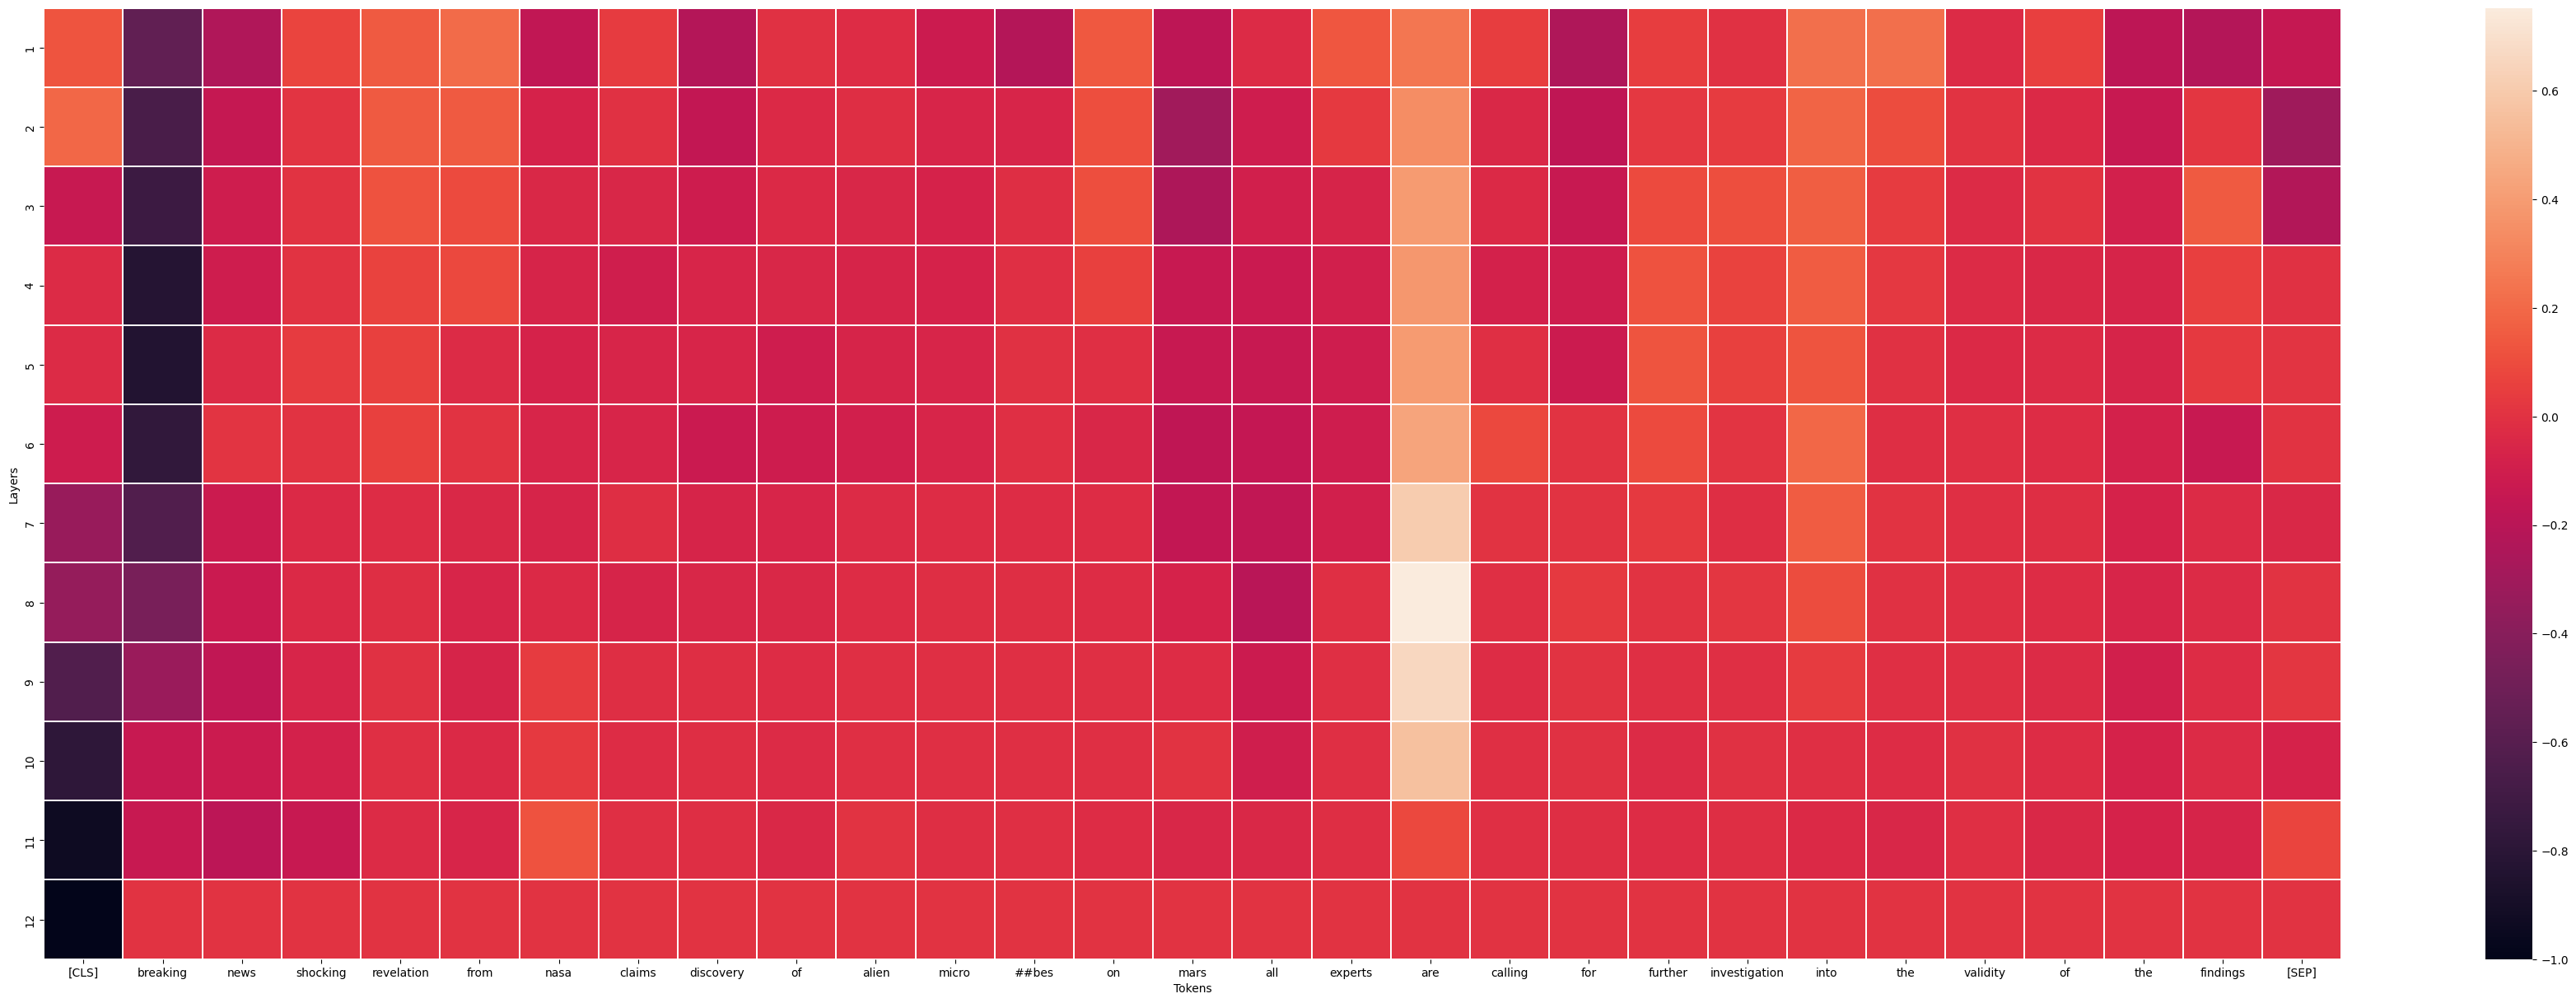

In [35]:
text_2 = "Breaking News Shocking revelation from NASA claims discovery of alien microbes on Mars all experts are calling for further investigation into the validity of the findings"
label_2 = 1 #hoax

get_visualizations(text_2, label_2)

 Visualization For Score 


Heatmap


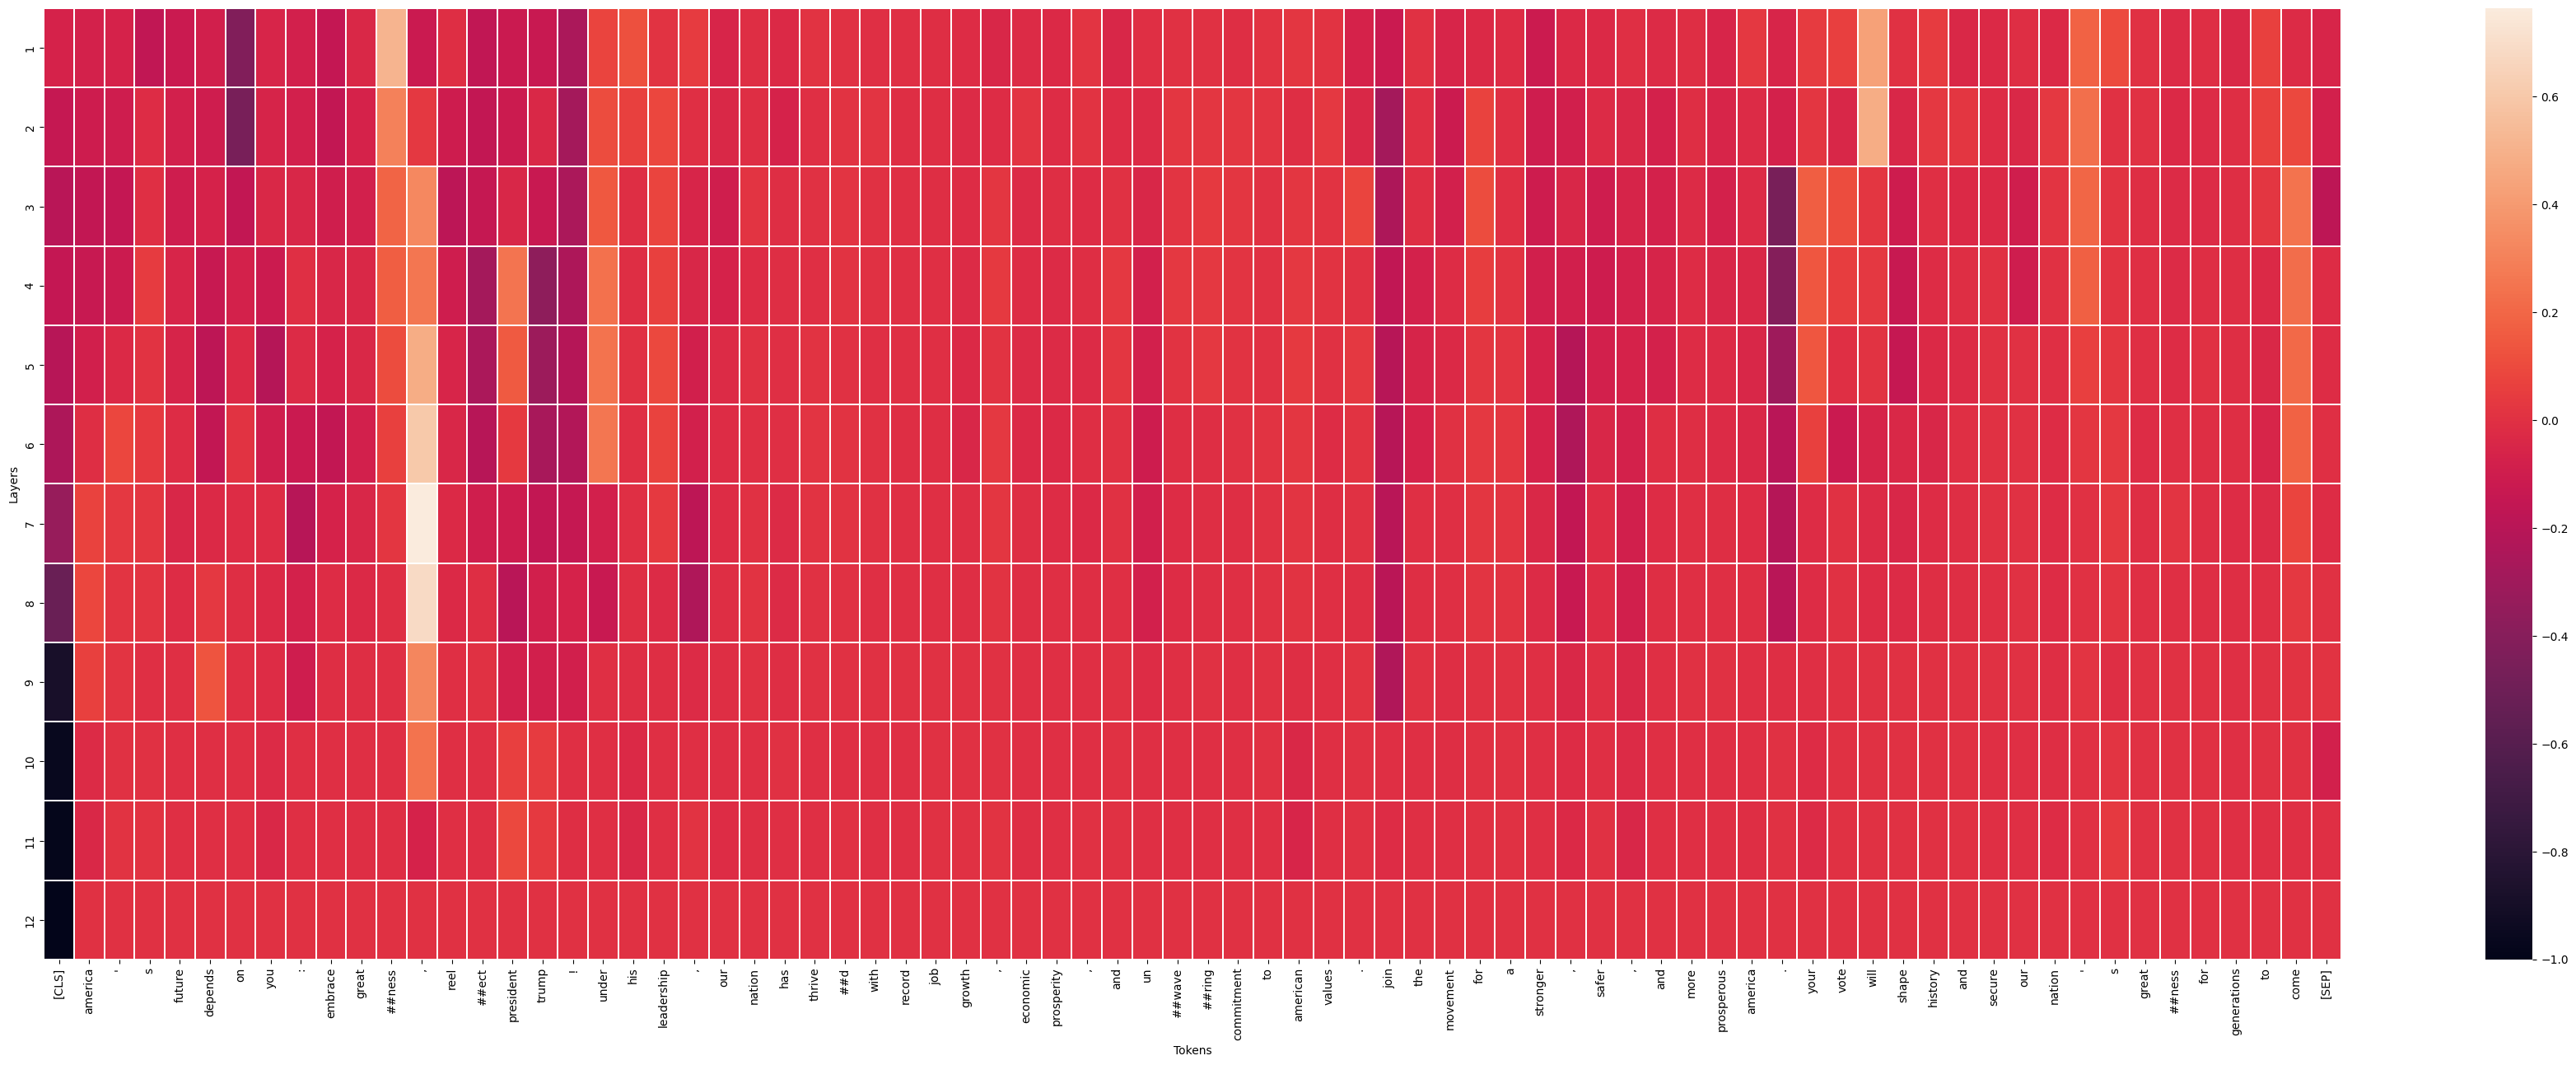

In [36]:
text_3 = "America's Future Depends on You: Embrace Greatness, Reelect President Trump! Under his leadership, our nation has thrived with record job growth, economic prosperity, and unwavering commitment to American values. Join the movement for a stronger, safer, and more prosperous America. Your vote will shape history and secure our nation's greatness for generations to come"
label_3 = 2 #Propoganda

get_visualizations(text_3, label_3)

 Visualization For Score 


Heatmap


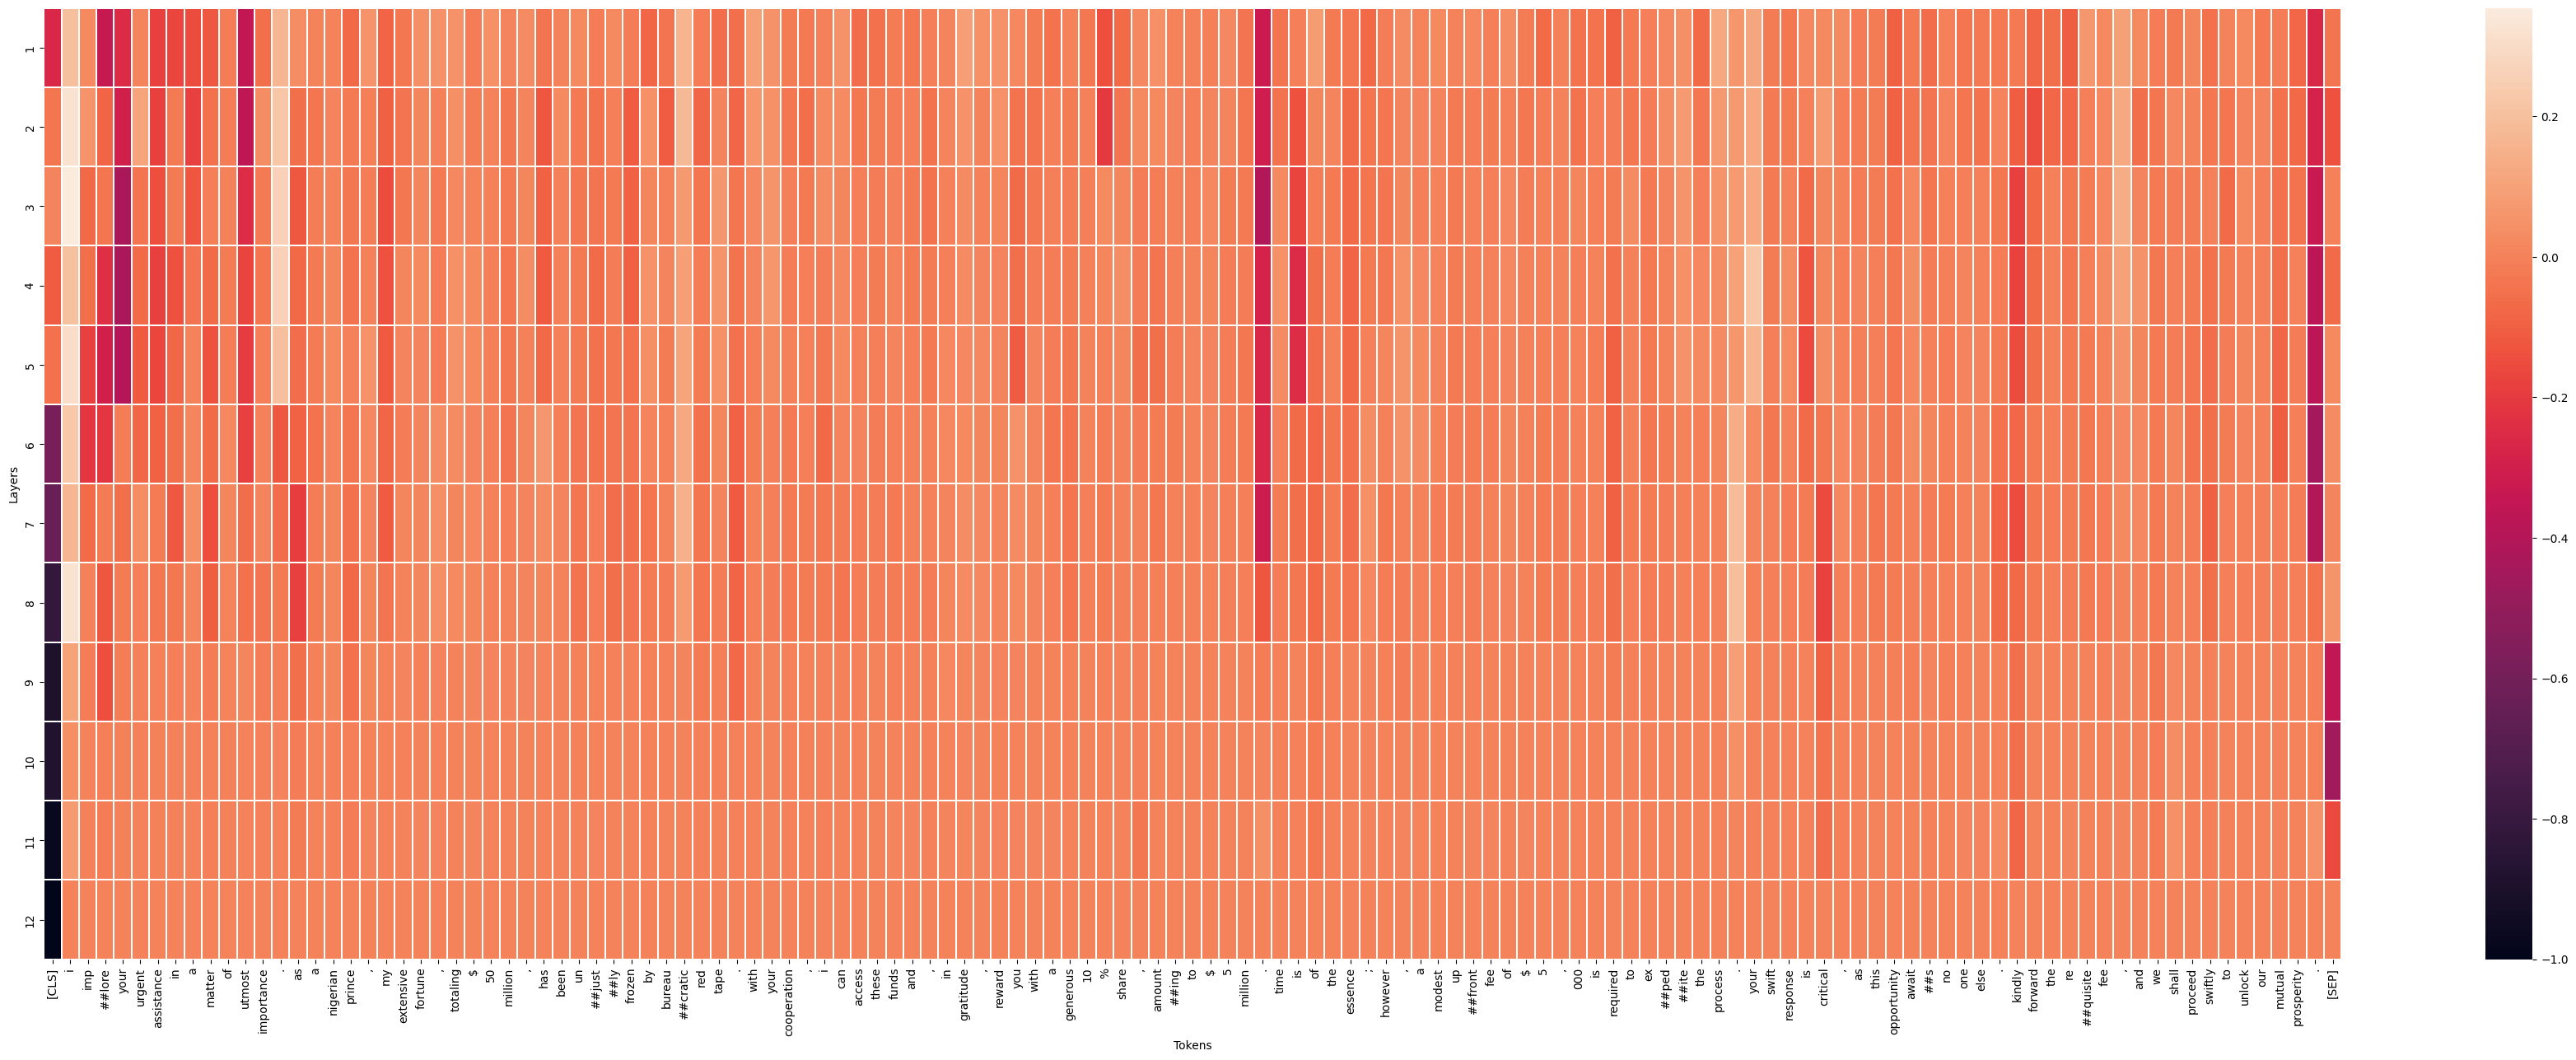

In [37]:
text_4 = "I implore your urgent assistance in a matter of utmost importance. As a Nigerian prince, my extensive fortune, totaling $50 million, has been unjustly frozen by bureaucratic red tape. With your cooperation, I can access these funds and, in gratitude, reward you with a generous 10% share, amounting to $5 million. Time is of the essence; however, a modest upfront fee of $5,000 is required to expedite the process. Your swift response is critical, as this opportunity awaits no one else. Kindly forward the requisite fee, and we shall proceed swiftly to unlock our mutual prosperity."
label_4 = 1
get_visualizations(text_4, label_4)

 Visualization For Score 


Heatmap


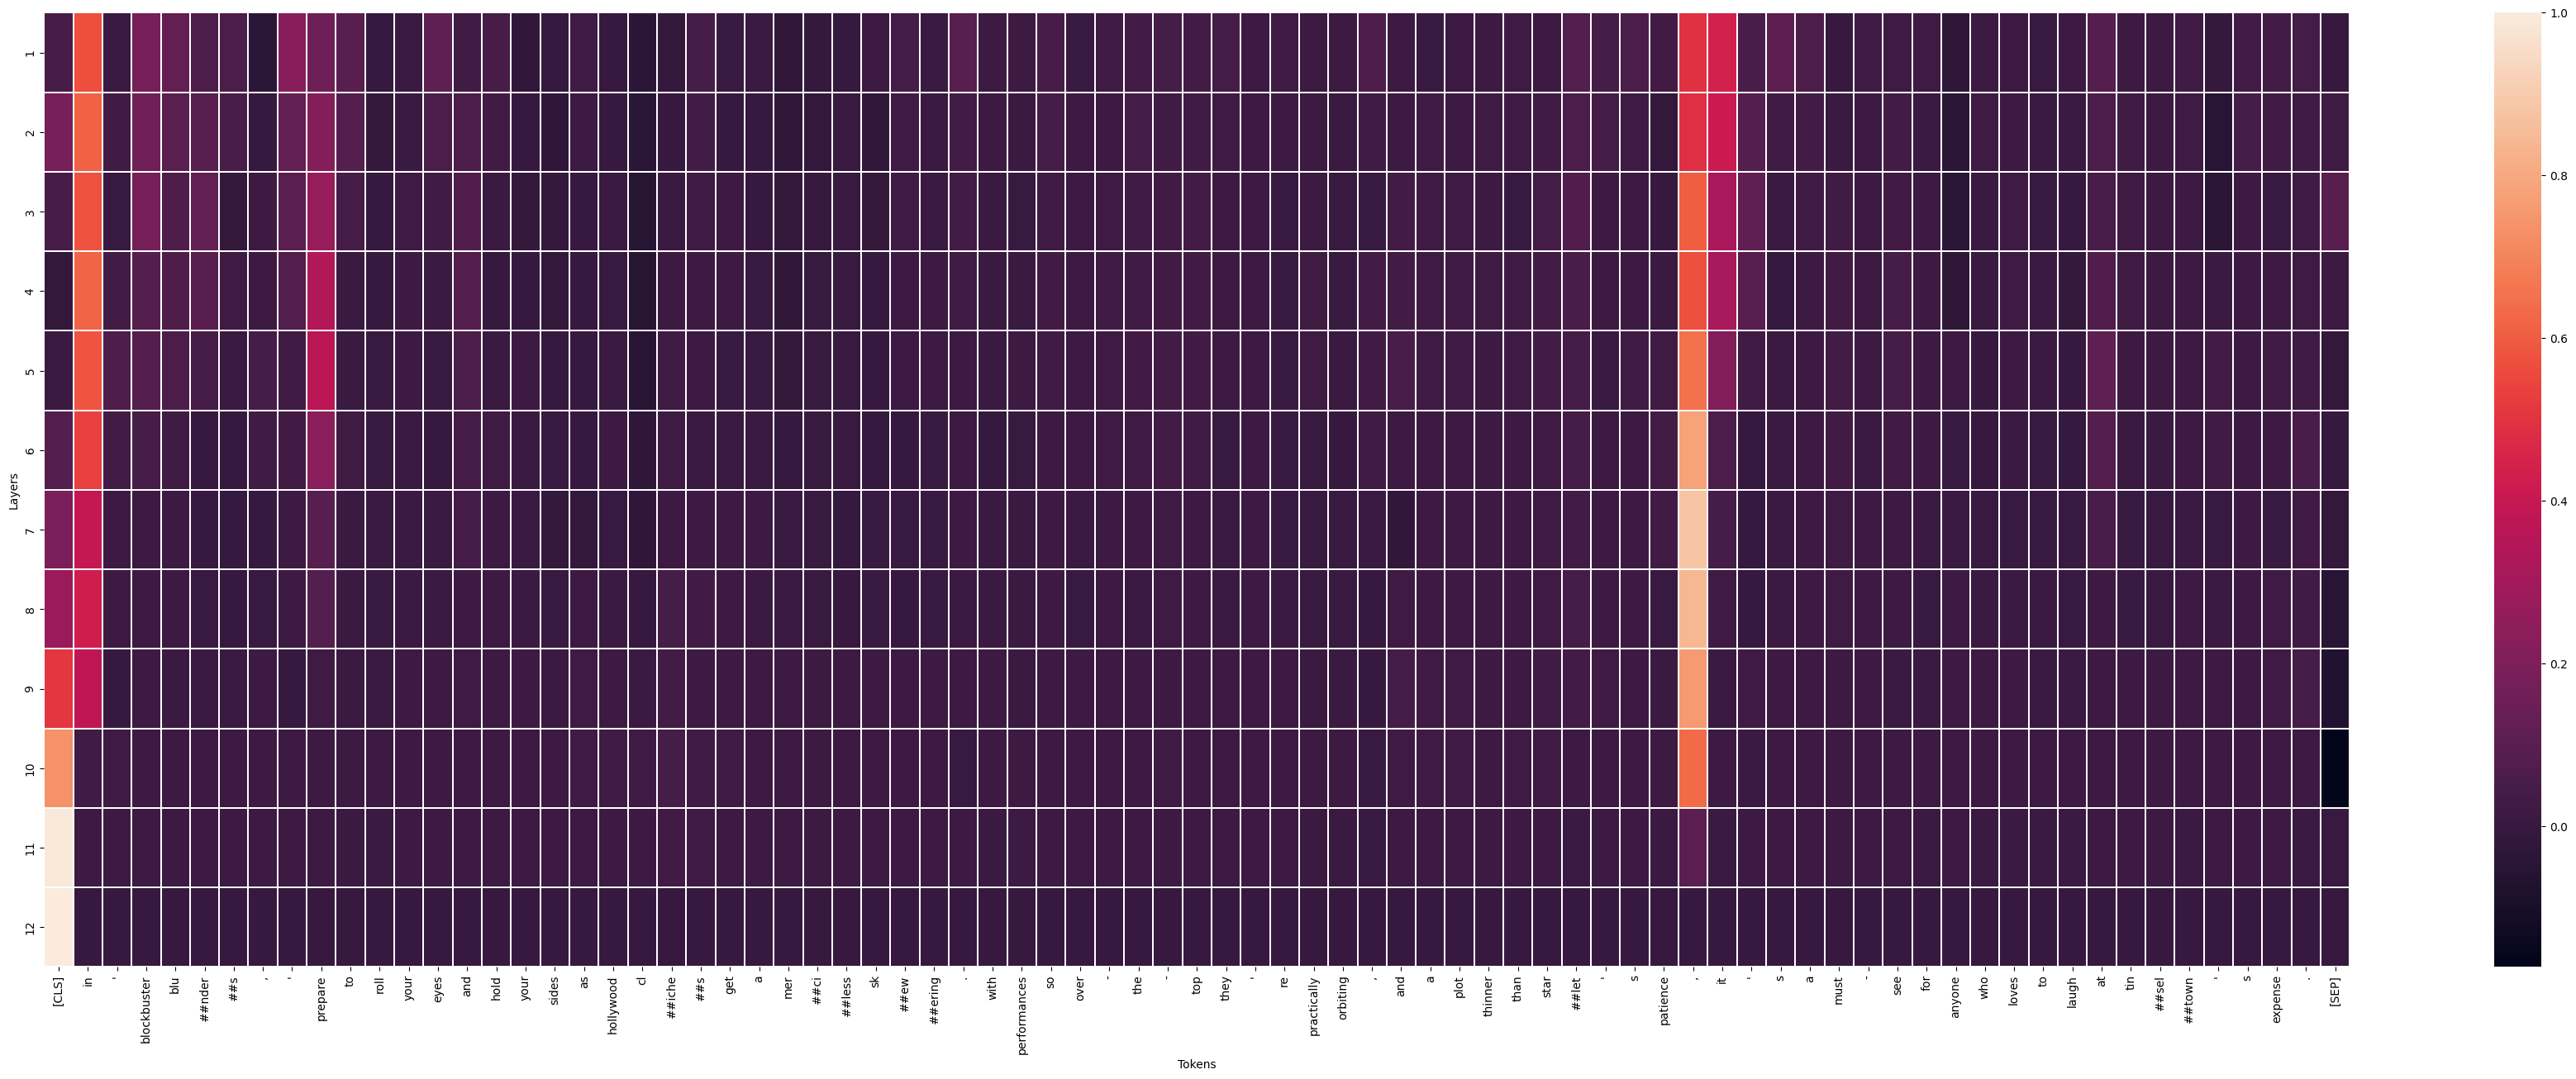

In [38]:
text_5 = "In 'Blockbuster Blunders,' prepare to roll your eyes and hold your sides as Hollywood clichés get a merciless skewering. With performances so over-the-top they're practically orbiting, and a plot thinner than starlet's patience, it's a must-see for anyone who loves to laugh at Tinseltown's expense."
label_5 = 0
get_visualizations(text_5, label_5)